In [1]:
import pandas as pd

## Data Loading

In [2]:
# Load the training datasets
train_files = [
    "train-1.csv",
    "train-2.csv",
    "train-3.csv",
    "train-4.csv",
    "train-5.csv",
    "train-6.csv",
    "train-7.csv",
    "train-8.csv",
]

# Concatenate all training data into a single DataFrame
train_data = pd.concat([pd.read_csv(f) for f in train_files], ignore_index=True)

# Load the validation and test datasets
validation_data = pd.read_csv("validation_hidden.csv")
test_data = pd.read_csv("test_hidden.csv")

# Display the first few rows of the training data to understand its structure
train_data.head()

,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label
0,4,tt0010600,The Doll,Die Puppe,1919,\N,66,1898.0,True
1,7,tt0011841,Way Down East,Way Down East,1920,\N,145,5376.0,True
2,9,tt0012494,Déstiny,Der müde Tod,1921,\N,97,5842.0,True
3,25,tt0015163,The Navigator,The Navigator,1924,\N,59,9652.0,True
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93,17887.0,True


In [3]:
validation_data

,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes
0,0,tt0003740,Cabiria,NaN,1914,\N,148,3452.0
1,1,tt0008663,A Man There Was,Terje Vigen,1917,\N,65,1882.0
2,3,tt0010307,J'accuse!,NaN,1919,\N,166,1692.0
3,18,tt0014429,Safety Last!,Safety Last!,1923,\N,74,19898.0
4,27,tt0015175,Die Nibelungen: Siegfried,NaN,1924,\N,143,5676.0
...,...,...,...,...,...,...,...,...
950,9974,tt9686154,You Will Die at 20,NaN,2019,\N,103,2106.0
951,9976,tt9690328,Pápér Spidérs,Paper Spiders,2020,\N,109,NaN
952,9980,tt9735790,Me You Madness,Me You Madness,2021,\N,98,1056.0
953,9984,tt9769668,Tughlaq Durbar,Tughlaq Durbar,2021,\N,145,1430.0


### Data clean

In [4]:
train_data.drop('Unnamed: 0', axis=1, inplace=True)
validation_data.drop('Unnamed: 0', axis=1, inplace=True)
test_data.drop('Unnamed: 0', axis=1, inplace=True)

# Replace '\\N' values with NaN and convert necessary columns to appropriate data types
for df in [train_data, validation_data, test_data]:
    df.replace({'\\N': None}, inplace=True)
    df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce')
    df['endYear'] = pd.to_numeric(df['endYear'], errors='coerce')
    df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')
    
# Check for missing values in the training data
missing_values = train_data.isnull().sum()

# Display the missing value counts and data types of the columns
missing_values, train_data.dtypes

(tconst               0
 primaryTitle         0
 originalTitle     3988
 startYear          786
 endYear           7173
 runtimeMinutes      13
 numVotes           790
 label                0
 dtype: int64,
 tconst             object
 primaryTitle       object
 originalTitle      object
 startYear         float64
 endYear           float64
 runtimeMinutes    float64
 numVotes          float64
 label                bool
 dtype: object)

1. Impute missing 'originalTitle' with 'primaryTitle'
2. Adjusting the 'startYear' and 'endYear' to a single 'year' feature. If both startYear and endYear are present, we take the median, otherwise, we take the available value.
3. Impute missing 'runtimeMinutes' with their median
4. Impute missing 'numVotes' with 1 assuming titles with missing values received only 1 vote

In [5]:
for df in [train_data, validation_data, test_data]:
    # Impute missing 'originalTitle' with 'primaryTitle'
    df['originalTitle'].fillna(df['primaryTitle'], inplace=True)

    # Where both years are available, set 'year' to their median
    both_years_present = df[(df['startYear'].notnull()) & (df['endYear'].notnull())].index
    df.loc[both_years_present, 'year'] = df.loc[both_years_present, ['startYear', 'endYear']].median(axis=1)
    
    # Where only one of the years is available, use it as the 'year' value
    df['year'] = df['year'].fillna(df['startYear']).fillna(df['endYear'])
    
    # Now we can drop the 'startYear' and 'endYear' columns as they are no longer needed
    df.drop(['startYear', 'endYear'], axis=1, inplace=True)
    # Impute missing 'runtimeMinutes' with their median
    df['runtimeMinutes'].fillna(df['runtimeMinutes'].median(), inplace=True)
    # Impute missing 'numVotes' with 1 assuming titles with missing values received only 1 vote
    df['numVotes'].fillna(1, inplace=True)

In [6]:
# Reordering the columns to move 'year' to the left of 'label'
def reorder_columns(dataframe):
    cols = list(dataframe.columns)
    cols.insert(-2, cols.pop(cols.index('year')))  
    return dataframe[cols]

# Apply the reordering to each dataframe
train_data = reorder_columns(train_data)
validation_data = reorder_columns(validation_data)
test_data = reorder_columns(test_data)

In [7]:
train_data

,tconst,primaryTitle,originalTitle,runtimeMinutes,year,numVotes,label
0,tt0010600,The Doll,Die Puppe,66.0,1919.0,1898.0,True
1,tt0011841,Way Down East,Way Down East,145.0,1920.0,5376.0,True
2,tt0012494,Déstiny,Der müde Tod,97.0,1921.0,5842.0,True
3,tt0015163,The Navigator,The Navigator,59.0,1924.0,9652.0,True
4,tt0016220,The Phantom of the Opera,The Phantom of the Opera,93.0,1925.0,17887.0,True
...,...,...,...,...,...,...,...
7954,tt9625664,Trauma Center,Trauma Center,87.0,2019.0,12951.0,False
7955,tt9741310,Slaxx,Slaxx,77.0,2020.0,2464.0,False
7956,tt9742392,Kindred,Kindred,101.0,2020.0,1719.0,False
7957,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,The Bee Gees: How Can You Mend a Broken Heart,111.0,2020.0,4144.0,True


In [8]:
train_data.to_csv('train.csv')

In [9]:
train_data1 = train_data
train_data1

,tconst,primaryTitle,originalTitle,runtimeMinutes,year,numVotes,label
0,tt0010600,The Doll,Die Puppe,66.0,1919.0,1898.0,True
1,tt0011841,Way Down East,Way Down East,145.0,1920.0,5376.0,True
2,tt0012494,Déstiny,Der müde Tod,97.0,1921.0,5842.0,True
3,tt0015163,The Navigator,The Navigator,59.0,1924.0,9652.0,True
4,tt0016220,The Phantom of the Opera,The Phantom of the Opera,93.0,1925.0,17887.0,True
...,...,...,...,...,...,...,...
7954,tt9625664,Trauma Center,Trauma Center,87.0,2019.0,12951.0,False
7955,tt9741310,Slaxx,Slaxx,77.0,2020.0,2464.0,False
7956,tt9742392,Kindred,Kindred,101.0,2020.0,1719.0,False
7957,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,The Bee Gees: How Can You Mend a Broken Heart,111.0,2020.0,4144.0,True


## Exploratory Data Analysis (EDA)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

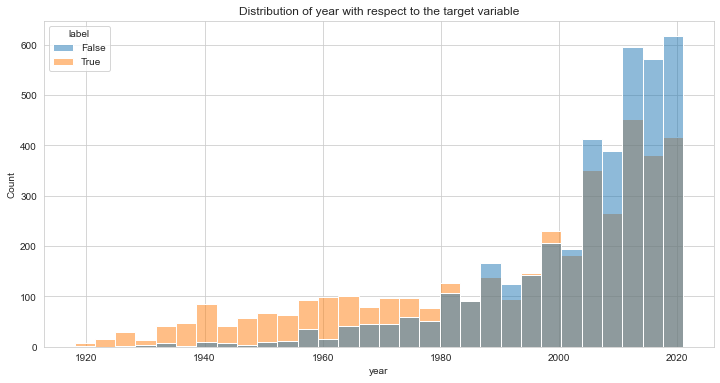

In [11]:
# Setting up the aesthetics for the plots
sns.set_style("whitegrid")

# Analyzing the distribution of the target variable 'label'
target_distribution = train_data['label'].value_counts(normalize=True)

# Analyzing the distributions and relationships of numerical features with the target variable
# Distribution of 'startYear'
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='year', hue='label', bins=30, kde=False)
plt.title('Distribution of year with respect to the target variable')
plt.show()

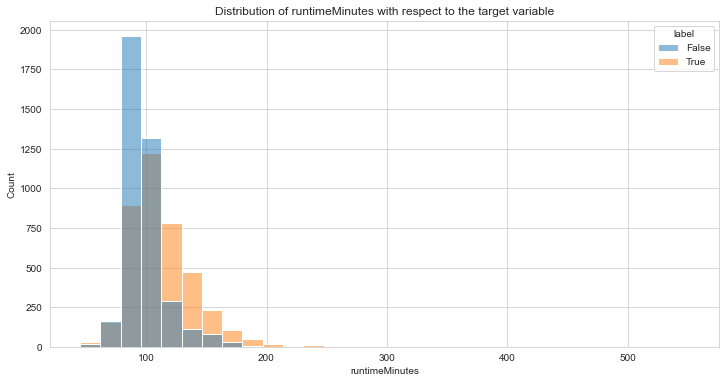

In [12]:
# Distribution of 'runtimeMinutes'
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='runtimeMinutes', hue='label', bins=30, kde=False)
plt.title('Distribution of runtimeMinutes with respect to the target variable')
plt.show()

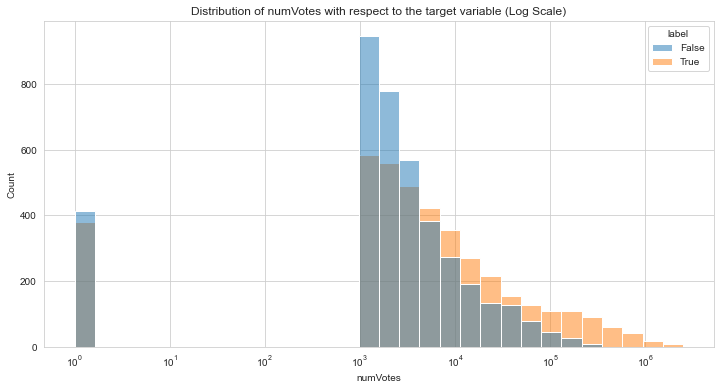

In [13]:
# Distribution of 'numVotes'
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='numVotes', hue='label', log_scale=True, bins=30, kde=False)
plt.title('Distribution of numVotes with respect to the target variable (Log Scale)')
plt.show()

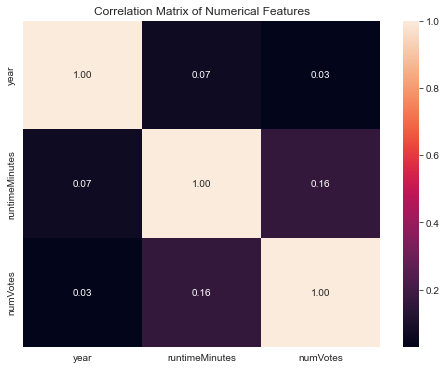

In [15]:
# Correlation matrix for numerical features
numerical_features = ['year', 'runtimeMinutes', 'numVotes']
correlation_matrix = train_data[numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Extra Data

In [16]:
import duckdb

ratings_df = pd.read_csv('ml-20m/ratings.csv')
links_df = pd.read_csv('ml-20m/links.csv')

con = duckdb.connect(database=':memory:', read_only=False)
con.register('ratings', ratings_df)
con.register('links', links_df)
con.register('train_data', train_data)

In [17]:
# Use DuckDB to calculate the average rating per movie
avg_ratings = con.execute("""
SELECT movieId, AVG(rating) AS avg_rating
FROM ratings
GROUP BY movieId
""").df()
con.register('avg_ratings', avg_ratings)

In [18]:
df_rating = con.execute("""
SELECT l.movieId, l.imdbId, a.avg_rating
FROM links l
JOIN avg_ratings a ON l.movieId = a.movieId
""").df()
con.register('df_rating', df_rating)

In [19]:
df_rating

,movieId,imdbId,avg_rating
0,1,114709,3.921240
1,2,113497,3.211977
2,3,113228,3.151040
3,4,114885,2.861393
4,5,113041,3.064592
...,...,...,...
26739,129937,2199571,2.666667
26740,131116,1350940,3.500000
26741,128671,3409392,3.428571
26742,129707,2918436,2.500000


In [20]:
train_rating = con.execute("""
    SELECT 
        train_data.*, 
        df_rating.avg_rating
    FROM 
        train_data
    JOIN 
        df_rating ON CAST(SUBSTR(train_data.tconst, 3) AS INTEGER) = df_rating.imdbId
""").fetchdf()
con.register('train_rating', train_rating)

In [21]:
train_rating

,tconst,primaryTitle,originalTitle,runtimeMinutes,year,numVotes,label,avg_rating
0,tt0113277,Heat,Heat,170.0,1995.0,616475.0,True,3.834930
1,tt0112453,Balto,Balto,78.0,1995.0,42057.0,True,3.272416
2,tt0114388,Sense and Sensibility,Sense and Sensibility,136.0,1995.0,1.0,True,3.968573
3,tt0113845,Money Train,Money Train,110.0,1995.0,40354.0,False,2.880754
4,tt0113627,Leaving Las Vegas,Leaving Las Vegas,111.0,1995.0,120030.0,True,3.689510
...,...,...,...,...,...,...,...,...
3993,tt0080100,The Visitor,The Visitor,108.0,1979.0,3581.0,False,2.666667
3994,tt1294970,The Angriest Man in Brooklyn,The Angriest Man in Brooklyn,83.0,2014.0,21994.0,False,2.805556
3995,tt3797142,Bachelor Night,Bachelor Night,88.0,2014.0,1636.0,False,2.500000
3996,tt3409392,Timbuktu,Timbuktu,96.0,2014.0,17114.0,True,3.428571


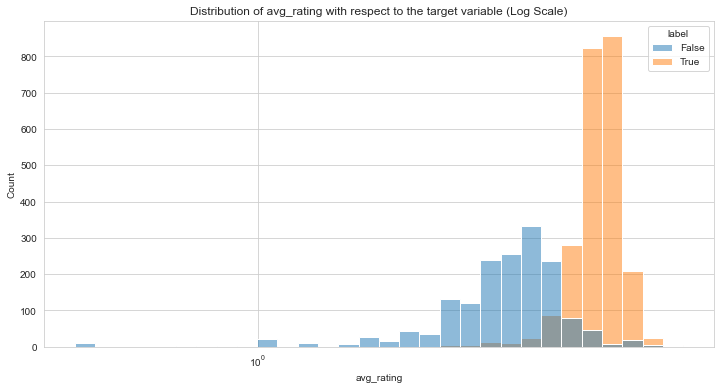

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train_rating, x='avg_rating', hue='label', log_scale=True, bins=30, kde=False)
plt.title('Distribution of avg_rating with respect to the target variable (Log Scale)')
plt.show()

In [23]:
rating_stats = train_rating['avg_rating'].describe()

rating_label_distribution = train_rating.groupby('label')['avg_rating'].agg(['mean', 'std', 'min', 'max'])

rating_stats, rating_label_distribution

(count    3998.000000
 mean        3.190870
 std         0.679110
 min         0.500000
 25%         2.733428
 50%         3.404509
 75%         3.708955
 max         5.000000
 Name: avg_rating, dtype: float64,
            mean       std  min  max
 label                              
 False  2.574020  0.554766  0.5  5.0
 True   3.624795  0.336368  0.5  5.0)

In [24]:
mean_true = rating_label_distribution.loc[True, 'mean']
mean_false = rating_label_distribution.loc[False, 'mean']
threshold = (mean_true + mean_false) / 2

print("Threshold:", threshold)

Threshold: 3.0994072416394065


In [28]:
# Assigns a label of True or False based on the threshold value to the avg_rating column
def assign_label_based_on_threshold(rating_df, threshold):
    rating_df['rating_label'] = rating_df['avg_rating'].apply(lambda x: x >= threshold)
    return rating_df

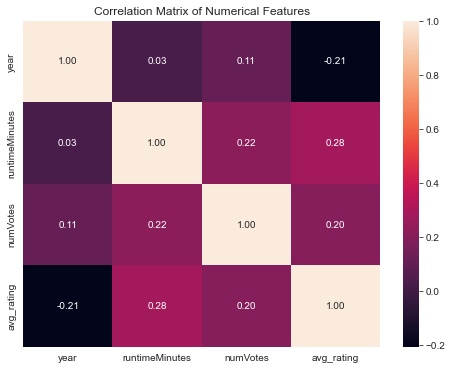

In [25]:
# Correlation matrix for numerical features
numerical_features = ['year', 'runtimeMinutes', 'numVotes', 'avg_rating']
correlation_matrix = train_rating[numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [26]:
# Get rest part of the dataset
train_subset = con.execute("""
SELECT td.tconst, td.primaryTitle, td.originalTitle, td.runtimeMinutes, td.year, td.numVotes, td.label, 
FROM train_data td
LEFT JOIN train_rating tr ON td.tconst = tr.tconst
WHERE tr.tconst IS NULL
""").fetchdf()

con.register('train_subset', train_subset)

### Linear regression

In [29]:
from sklearn.linear_model import LinearRegression
X_train = train_rating[['runtimeMinutes', 'year', 'numVotes']]
y_train = train_rating['avg_rating']

model = LinearRegression()
model.fit(X_train, y_train)

X_test = train_subset[['runtimeMinutes', 'year', 'numVotes']]
predicted_avg_rating = model.predict(X_test)
train_subset['avg_rating'] = predicted_avg_rating


train_subset = assign_label_based_on_threshold(train_subset, threshold)
train_subset

,tconst,primaryTitle,originalTitle,runtimeMinutes,year,numVotes,label,avg_rating,rating_label
0,tt0010600,The Doll,Die Puppe,66.0,1919.0,1898.0,True,3.380559,True
1,tt0023973,Thé Éáglé ánd thé Háwk,Thé Éáglé ánd thé Háwk,73.0,1933.0,1.0,True,3.329314,True
2,tt0035009,The Mad Monster,The Mad Monster,77.0,1942.0,1720.0,False,3.295397,True
3,tt0037939,The Naughty Nineties,The Naughty Nineties,76.0,1945.0,1957.0,True,3.268113,True
4,tt0039676,The October Man,The October Man,95.0,1947.0,1260.0,True,3.381594,True
...,...,...,...,...,...,...,...,...,...
3956,tt9625664,Trauma Center,Trauma Center,87.0,2019.0,12951.0,False,2.839359,False
3957,tt9741310,Slaxx,Slaxx,77.0,2020.0,2464.0,False,2.756607,False
3958,tt9742392,Kindred,Kindred,101.0,2020.0,1719.0,False,2.917531,False
3959,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,The Bee Gees: How Can You Mend a Broken Heart,111.0,2020.0,4144.0,True,2.986809,False


In [30]:
train_data1

,tconst,primaryTitle,originalTitle,runtimeMinutes,year,numVotes,label
0,tt0010600,The Doll,Die Puppe,66.0,1919.0,1898.0,True
1,tt0011841,Way Down East,Way Down East,145.0,1920.0,5376.0,True
2,tt0012494,Déstiny,Der müde Tod,97.0,1921.0,5842.0,True
3,tt0015163,The Navigator,The Navigator,59.0,1924.0,9652.0,True
4,tt0016220,The Phantom of the Opera,The Phantom of the Opera,93.0,1925.0,17887.0,True
...,...,...,...,...,...,...,...
7954,tt9625664,Trauma Center,Trauma Center,87.0,2019.0,12951.0,False
7955,tt9741310,Slaxx,Slaxx,77.0,2020.0,2464.0,False
7956,tt9742392,Kindred,Kindred,101.0,2020.0,1719.0,False
7957,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,The Bee Gees: How Can You Mend a Broken Heart,111.0,2020.0,4144.0,True


In [73]:
# merge two subsets and join them to train_data
merged_data = pd.concat([train_subset, train_rating], ignore_index=True)
merged_data

train_data1 = train_data1.merge(merged_data[['tconst', 'rating_label','avg_rating']], on='tconst', how='left')

# Calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(train_data1['label'], train_data1['rating_label'])
print("Accuracy：", accuracy)

Accuracy： 0.8012313104661389


## Validation data

In [31]:
con.register('validation_data', validation_data)
validation_data

,tconst,primaryTitle,originalTitle,year,runtimeMinutes,numVotes
0,tt0003740,Cabiria,Cabiria,1914.0,148.0,3452.0
1,tt0008663,A Man There Was,Terje Vigen,1917.0,65.0,1882.0
2,tt0010307,J'accuse!,J'accuse!,1919.0,166.0,1692.0
3,tt0014429,Safety Last!,Safety Last!,1923.0,74.0,19898.0
4,tt0015175,Die Nibelungen: Siegfried,Die Nibelungen: Siegfried,1924.0,143.0,5676.0
...,...,...,...,...,...,...
950,tt9686154,You Will Die at 20,You Will Die at 20,2019.0,103.0,2106.0
951,tt9690328,Pápér Spidérs,Paper Spiders,2020.0,109.0,1.0
952,tt9735790,Me You Madness,Me You Madness,2021.0,98.0,1056.0
953,tt9769668,Tughlaq Durbar,Tughlaq Durbar,2021.0,145.0,1430.0


In [32]:
validation_rating = con.execute("""
    SELECT 
        validation_data.*, 
        df_rating.avg_rating
    FROM 
        validation_data
    JOIN 
        df_rating ON CAST(SUBSTR(validation_data.tconst, 3) AS INTEGER) = df_rating.imdbId
""").fetchdf()
con.register('validation_rating', validation_rating)

In [33]:
validation_rating

,tconst,primaryTitle,originalTitle,year,runtimeMinutes,numVotes,avg_rating
0,tt0115683,Bio-Dome,Bio-Dome,1996.0,88.0,27132.0,2.394223
1,tt0116839,Lawnmower Man 2: Beyond Cyberspace,Lawnmower Man 2: Beyond Cyberspace,1996.0,93.0,9451.0,2.144243
2,tt0113247,La Haine,La haine,1995.0,98.0,162601.0,3.996434
3,tt0116606,If Lucy Fell,If Lucy Fell,1996.0,92.0,4115.0,3.011004
4,tt0112461,The Basketball Diaries,The Basketball Diaries,1995.0,102.0,107119.0,3.582929
...,...,...,...,...,...,...,...
512,tt0293124,Erkan & Stefan gegen die Mächte der Finsternis,Erkan & Stefan gegen die Mächte der Finsternis,2002.0,80.0,1289.0,3.500000
513,tt0466713,Military Academy,Kein Bund fürs Leben,2007.0,85.0,1469.0,4.000000
514,tt0092974,Ernest Goes to Camp,Ernest Goes to Camp,1987.0,92.0,11340.0,2.155651
515,tt0360717,King Kong,King Kong,2005.0,187.0,409833.0,3.346733


In [36]:
# Get rest part of the val dataset
validation_subset = con.execute("""
SELECT vd.tconst, vd.primaryTitle, vd.originalTitle, vd.runtimeMinutes, vd.year, vd.numVotes,
FROM validation_data vd
LEFT JOIN validation_rating vr ON vd.tconst = vr.tconst
WHERE vr.tconst IS NULL
""").fetchdf()

con.register('validation_subset', validation_subset)

In [37]:
validation_subset

,tconst,primaryTitle,originalTitle,runtimeMinutes,year,numVotes
0,tt0034461,Aniki Bóbó,Aniki Bóbó,71.0,1942.0,1677.0
1,tt0039973,The Web,The Web,87.0,1947.0,1.0
2,tt0043545,Flight to Mars,Flight to Mars,72.0,1951.0,1108.0
3,tt0043910,Payment on Demand,Payment on Demand,90.0,1951.0,1645.0
4,tt0044716,The Holly and the Ivy,The Holly and the Ivy,83.0,1952.0,1430.0
...,...,...,...,...,...,...
433,tt9686154,You Will Die at 20,You Will Die at 20,103.0,2019.0,2106.0
434,tt9690328,Pápér Spidérs,Paper Spiders,109.0,2020.0,1.0
435,tt9735790,Me You Madness,Me You Madness,98.0,2021.0,1056.0
436,tt9769668,Tughlaq Durbar,Tughlaq Durbar,145.0,2021.0,1430.0


In [38]:
X_validation = validation_subset[['runtimeMinutes', 'year', 'numVotes']]
predicted_avg_rating = model.predict(X_validation)
validation_subset.loc[:, 'avg_rating'] = predicted_avg_rating

In [40]:
# merge two subsets 
merged_validation = pd.concat([validation_subset, validation_rating], ignore_index=True)
validation_data1 = validation_data.merge(merged_validation[['tconst', 'avg_rating']], on='tconst', how='left')

In [41]:
validation_data1

,tconst,primaryTitle,originalTitle,year,runtimeMinutes,numVotes,avg_rating
0,tt0003740,Cabiria,Cabiria,1914.0,148.0,3452.0,3.111111
1,tt0008663,A Man There Was,Terje Vigen,1917.0,65.0,1882.0,3.750000
2,tt0010307,J'accuse!,J'accuse!,1919.0,166.0,1692.0,3.875000
3,tt0014429,Safety Last!,Safety Last!,1923.0,74.0,19898.0,3.935737
4,tt0015175,Die Nibelungen: Siegfried,Die Nibelungen: Siegfried,1924.0,143.0,5676.0,3.976190
...,...,...,...,...,...,...,...
950,tt9686154,You Will Die at 20,You Will Die at 20,2019.0,103.0,2106.0,2.938222
951,tt9690328,Pápér Spidérs,Paper Spiders,2020.0,109.0,1.0,2.969977
952,tt9735790,Me You Madness,Me You Madness,2021.0,98.0,1056.0,2.889885
953,tt9769668,Tughlaq Durbar,Tughlaq Durbar,2021.0,145.0,1430.0,3.206520


In [43]:
validation_data1 = assign_label_based_on_threshold(validation_data1, threshold)
validation_data1

,tconst,primaryTitle,originalTitle,year,runtimeMinutes,numVotes,avg_rating,rating_label
0,tt0003740,Cabiria,Cabiria,1914.0,148.0,3452.0,3.111111,True
1,tt0008663,A Man There Was,Terje Vigen,1917.0,65.0,1882.0,3.750000,True
2,tt0010307,J'accuse!,J'accuse!,1919.0,166.0,1692.0,3.875000,True
3,tt0014429,Safety Last!,Safety Last!,1923.0,74.0,19898.0,3.935737,True
4,tt0015175,Die Nibelungen: Siegfried,Die Nibelungen: Siegfried,1924.0,143.0,5676.0,3.976190,True
...,...,...,...,...,...,...,...,...
950,tt9686154,You Will Die at 20,You Will Die at 20,2019.0,103.0,2106.0,2.938222,False
951,tt9690328,Pápér Spidérs,Paper Spiders,2020.0,109.0,1.0,2.969977,False
952,tt9735790,Me You Madness,Me You Madness,2021.0,98.0,1056.0,2.889885,False
953,tt9769668,Tughlaq Durbar,Tughlaq Durbar,2021.0,145.0,1430.0,3.206520,True


In [45]:
validation_data1[['rating_label']].to_csv('validation.txt', index=False, header=False, sep='\t')

## Test Data

In [46]:
con.register('test_data', test_data)
test_data

,tconst,primaryTitle,originalTitle,year,runtimeMinutes,numVotes
0,tt0014972,He Who Gets Slapped,He Who Gets Slapped,1924.0,95.0,3654.0
1,tt0015016,The Iron Horse,The Iron Horse,1924.0,150.0,2136.0
2,tt0015174,Die Nibelungen: Kriemhild's Revenge,Die Nibelungen: Kriemhild's Revenge,1924.0,129.0,4341.0
3,tt0015214,At 3:25,At 3:25,1925.0,59.0,1724.0
4,tt0015863,Go West,Go West,1925.0,69.0,4188.0
...,...,...,...,...,...,...
1081,tt9430698,One Piece: Stampede,One Piece: Stampede,2019.0,101.0,5109.0
1082,tt9441638,The Big Ugly,The Big Ugly,2020.0,106.0,5780.0
1083,tt9495690,Págálpánti,Pagalpanti,2019.0,149.0,2331.0
1084,tt9519642,The Wedding Unplanner,The Wedding Unplanner,2020.0,110.0,1.0


In [47]:
test_rating = con.execute("""
    SELECT 
        test_data.*, 
        df_rating.avg_rating
    FROM 
        test_data
    JOIN 
        df_rating ON CAST(SUBSTR(test_data.tconst, 3) AS INTEGER) = df_rating.imdbId
""").fetchdf()
con.register('test_rating', test_rating)

In [49]:
# Get rest part of the test dataset
test_subset = con.execute("""
SELECT sd.tconst, sd.primaryTitle, sd.originalTitle, sd.runtimeMinutes, sd.year, sd.numVotes,
FROM test_data sd
LEFT JOIN test_rating sr ON sd.tconst = sr.tconst
WHERE sr.tconst IS NULL
""").fetchdf()

con.register('test_subset', test_subset)

In [50]:
test_subset

,tconst,primaryTitle,originalTitle,runtimeMinutes,year,numVotes
0,tt0015214,At 3:25,At 3:25,59.0,1925.0,1724.0
1,tt0027442,Chárlié Chán's Sécrét,Charlie Chan's Secret,72.0,1936.0,1548.0
2,tt0034027,'Pimpernel' Smith,'Pimpernel' Smith,120.0,1941.0,1533.0
3,tt0039563,O Leão da Estrela,O Leão da Estrela,121.0,1947.0,1145.0
4,tt0039666,Nora Prentiss,Nora Prentiss,111.0,1947.0,1672.0
...,...,...,...,...,...,...
524,tt9430698,One Piece: Stampede,One Piece: Stampede,101.0,2019.0,5109.0
525,tt9441638,The Big Ugly,The Big Ugly,106.0,2020.0,5780.0
526,tt9495690,Págálpánti,Pagalpanti,149.0,2019.0,2331.0
527,tt9519642,The Wedding Unplanner,The Wedding Unplanner,110.0,2020.0,1.0


In [51]:
X_test = test_subset[['runtimeMinutes', 'year', 'numVotes']]
predicted_avg_rating = model.predict(X_test)
test_subset.loc[:, 'avg_rating'] = predicted_avg_rating

In [52]:
# merge two subsets 
merged_test = pd.concat([test_subset, test_rating], ignore_index=True)
test_data1 = test_data.merge(merged_test[['tconst', 'avg_rating']], on='tconst', how='left')

In [53]:
test_data1

,tconst,primaryTitle,originalTitle,year,runtimeMinutes,numVotes,avg_rating
0,tt0014972,He Who Gets Slapped,He Who Gets Slapped,1924.0,95.0,3654.0,3.576923
1,tt0015016,The Iron Horse,The Iron Horse,1924.0,150.0,2136.0,3.800000
2,tt0015174,Die Nibelungen: Kriemhild's Revenge,Die Nibelungen: Kriemhild's Revenge,1924.0,129.0,4341.0,3.846154
3,tt0015214,At 3:25,At 3:25,1925.0,59.0,1724.0,3.291812
4,tt0015863,Go West,Go West,1925.0,69.0,4188.0,3.620172
...,...,...,...,...,...,...,...
1081,tt9430698,One Piece: Stampede,One Piece: Stampede,2019.0,101.0,5109.0,2.927205
1082,tt9441638,The Big Ugly,The Big Ugly,2020.0,106.0,5780.0,2.954488
1083,tt9495690,Págálpánti,Pagalpanti,2019.0,149.0,2331.0,3.248006
1084,tt9519642,The Wedding Unplanner,The Wedding Unplanner,2020.0,110.0,1.0,2.976708


In [55]:
test_data1 = assign_label_based_on_threshold(test_data1, threshold)
test_data1

,tconst,primaryTitle,originalTitle,year,runtimeMinutes,numVotes,avg_rating,rating_label
0,tt0014972,He Who Gets Slapped,He Who Gets Slapped,1924.0,95.0,3654.0,3.576923,True
1,tt0015016,The Iron Horse,The Iron Horse,1924.0,150.0,2136.0,3.800000,True
2,tt0015174,Die Nibelungen: Kriemhild's Revenge,Die Nibelungen: Kriemhild's Revenge,1924.0,129.0,4341.0,3.846154,True
3,tt0015214,At 3:25,At 3:25,1925.0,59.0,1724.0,3.291812,True
4,tt0015863,Go West,Go West,1925.0,69.0,4188.0,3.620172,True
...,...,...,...,...,...,...,...,...
1081,tt9430698,One Piece: Stampede,One Piece: Stampede,2019.0,101.0,5109.0,2.927205,False
1082,tt9441638,The Big Ugly,The Big Ugly,2020.0,106.0,5780.0,2.954488,False
1083,tt9495690,Págálpánti,Pagalpanti,2019.0,149.0,2331.0,3.248006,True
1084,tt9519642,The Wedding Unplanner,The Wedding Unplanner,2020.0,110.0,1.0,2.976708,False


In [56]:
test_data1[['rating_label']].to_csv('test.txt', index=False, header=False, sep='\t')